In [1]:
import numpy as np
import pandas as pd
import time

import random

import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

#import pickle5 as pickle
from scipy import stats

import matplotlib.ticker as tick

import sys
sys.path.append('..')
#from nsgp_vi2 import nsgpVI
from nsgp_vi import nsgpVI

# We'll use double precision throughout for better numerics.
dtype = np.float64

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

plt.style.use('ggplot') 
plt.style.use('seaborn-paper')
plt.style.use('seaborn-whitegrid')
#v3 i.e. version 3, given by the new way(third way) of calculating the batches

In [2]:
print(tfp.__version__)
print(tf.__version__)

0.13.0
2.5.0


In [3]:
df = pd.read_csv('../data/power.csv', thousands=',')
dates = pd.DatetimeIndex(df['Date'],dayfirst=True)#.values

dates = pd.DatetimeIndex(df['Date'],dayfirst=True)#.values
times = pd.DatetimeIndex(df['Time'])

T = (24*(dates.day-1) + times.hour  + times.minute/60.).astype(float).values[:,None]
X = df['Global_active_power'].astype('float').values.reshape(len(T),1)
#X = np.log(X)
meanX = np.mean(X)
X = X - meanX

print(T.shape)
print(X.shape)

(44640, 1)
(44640, 1)


No handles with labels found to put in legend.


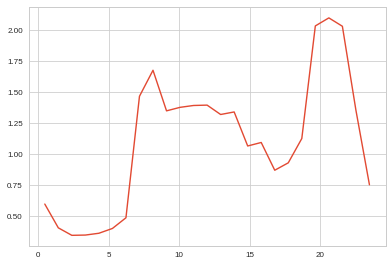

In [4]:
#df['Date']
#?pd.DatetimeIndex
minutes = (60.*times.hour  + times.minute).astype(float).values#[:,None]
gap = df['Global_active_power'].astype('float').values

bin_means, bin_edges, binnumber = stats.binned_statistic(minutes, gap, statistic='mean', bins=25)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure()
plt.plot(bin_centers/60., bin_means)
plt.legend(fontsize=10)
plt.show()

In [5]:

num_training_points_ = T.shape[0]

num_inducing_points_ = 24

inducing_index_points = np.linspace(0., 24., num_inducing_points_, endpoint=False)[..., np.newaxis]
np.random.shuffle(inducing_index_points)


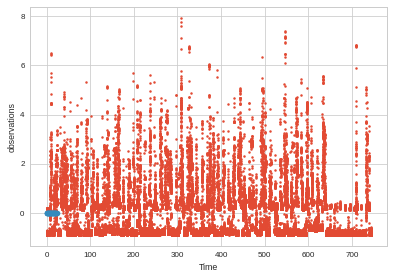

In [6]:
# Multiple individuals OU data with added noise
plt.plot(T,X,'.',markersize=5)
plt.xlabel('Time')
plt.ylabel('observations')

plt.plot(inducing_index_points,np.zeros_like(inducing_index_points),'o')
plt.show()

In [7]:
BATCH_SIZE=8
SEG_LENGTH=1024


class segment_generator:
    def __iter__(self):
        
        # loop over segments
        self.j = 0
        self.max_j = num_training_points_//SEG_LENGTH
        
        
        return self

    def __next__(self):
        

        if self.j==self.max_j:
            raise StopIteration

        TT = T[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        XX = X[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
    
        self.j += 1

        return TT,XX

        
dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64)) 
dataset = dataset.map(lambda dd: (dd[0],dd[1]))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
d_size = T.shape[0]//SEG_LENGTH//(BATCH_SIZE)

In [8]:

for d in dataset:
    print(d[0].shape)


(8, 1024, 1)
(8, 1024, 1)
(8, 1024, 1)
(8, 1024, 1)
(8, 1024, 1)


In [9]:


kernel_len_a = tfp.util.TransformedVariable(1.0, tfb.Softplus(),dtype=tf.float64, name='k_len_a',trainable=True)
kernel_len_l = tfp.util.TransformedVariable(1.0, tfb.Chain([tfb.Shift(np.float64(0.0)), tfb.Softplus()]),dtype=tf.float64, name='k_len_l',trainable=True)

# amplitude kernel parameters, lower levels
kernel_amp_a = tfp.util.TransformedVariable(1.0, tfb.Softplus(),dtype=tf.float64, name='k_amp_a',trainable=True)
kernel_amp_l = tfp.util.TransformedVariable(1.0, tfb.Softplus(),dtype=tf.float64, name='k_amp_l',trainable=True)

#kernels on the second layer
kernel_len = tfk.ExpSinSquared(kernel_len_a,kernel_len_l,period=np.float64(24.0))
kernel_amp = tfk.ExpSinSquared(kernel_amp_a,kernel_amp_l,period=np.float64(24.0))

vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,inducing_index_points=inducing_index_points,dataset=dataset,num_training_points=num_training_points_, num_sequential_samples=10,num_parallel_samples=10,init_observation_noise_variance=0.005**2)  


In [10]:
loss = vgp.optimize(BATCH_SIZE, SEG_LENGTH, NUM_EPOCHS=500)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Loss -1321.567981: 100%|██████████| 500/500 [3:10:31<00:00, 22.86s/it]  


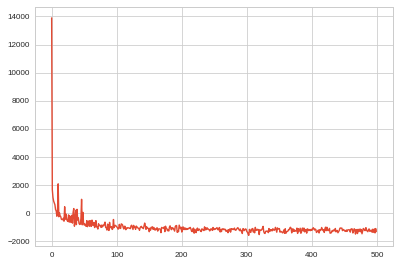

In [11]:
plt.plot(loss)
plt.show()



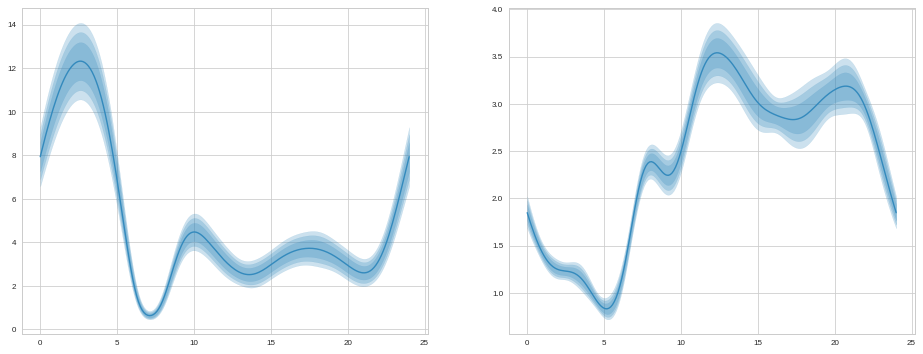

In [12]:

#ZZ = np.linspace(0,24*60,200)[:,None]
ZZ = np.linspace(0,24,200)[:,None]

len_mean, len_var = vgp.get_len_cond(ZZ[None,...],full_cov=False)
len_mean = len_mean[0,:,0].numpy()
len_std = len_var[:,0].numpy()**0.5



amp_mean, amp_var = vgp.get_amp_cond(ZZ[None,...],full_cov=False)
amp_mean = amp_mean[0,:,0].numpy()
amp_std = amp_var[:,0].numpy()**0.5



f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))


ax1.plot(ZZ,tf.math.softplus(vgp.mean_len + len_mean),color='C1')

ax1.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_len + len_mean - 1.28*len_std),tf.math.softplus(vgp.mean_len + len_mean + 1.28*len_std),color='C1',alpha=0.25)
ax1.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_len + len_mean - 1.96*len_std),tf.math.softplus(vgp.mean_len + len_mean + 1.96*len_std),color='C1',alpha=0.25)
ax1.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_len + len_mean - 2.58*len_std),tf.math.softplus(vgp.mean_len + len_mean + 2.58*len_std),color='C1',alpha=0.25)
#ax1.plot(T,true_len,'.',markersize=1,color='red')

ax2.plot(ZZ,tf.math.softplus(vgp.mean_amp + amp_mean),color='C1')

ax2.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_amp + amp_mean - 1.28*amp_std),tf.math.softplus(vgp.mean_amp + amp_mean + 1.28*amp_std),color='C1',alpha=0.25)
ax2.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_amp + amp_mean - 1.96*amp_std),tf.math.softplus(vgp.mean_amp + amp_mean + 1.96*amp_std),color='C1',alpha=0.25)
ax2.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_amp + amp_mean - 2.58*amp_std),tf.math.softplus(vgp.mean_amp + amp_mean + 2.58*amp_std),color='C1',alpha=0.25)

plt.show()
# plt.plot(ZZ,tf.math.softplus(vgp.mean_amp + amp_mean[0]+amp_var[:,0]**0.5),co

In [15]:
vgp.kernel_len.length_scale

<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.5199755553419868>

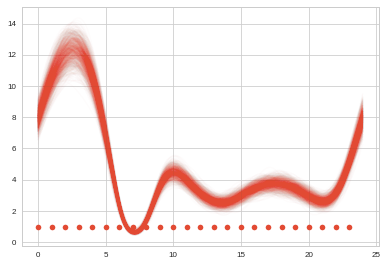

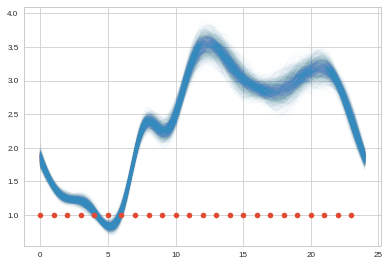

In [14]:
S=1000
ZZ = np.linspace(0,24,200)[:,None]
ZZ.shape
len_vals = tf.squeeze(vgp.get_len_samples(ZZ[None,...],S))
amp_vals = tf.squeeze(vgp.get_amp_samples(ZZ[None,...],S))


for i in range(S):
    plt.plot(ZZ,len_vals[i],color='C0',alpha=0.01)
#plt.plot(T,true_len,'.',markersize=1,color='blue')
plt.plot(vgp.len_inducing_index_points.numpy(), np.ones_like(vgp.len_inducing_index_points.numpy()),'o')


plt.show()

for i in range(S):
    plt.plot(ZZ,amp_vals[i],color='C1',alpha=0.01)
#plt.plot(T,true_var,'.',markersize=1,color='blue')
plt.plot(vgp.amp_inducing_index_points.numpy(), np.ones_like(vgp.amp_inducing_index_points.numpy()),'o')
plt.show()